# Store Discount Analysis

Overview:

In this analysis, superstore transaction data is acquired from a SQL database and prepared in Python. This data can then be analyzed to see if discount rates drive sales while maintaining profits for the company. Analysis will also be done to see how discount rates drive customer retention and quantity of items sold.

Through this analysis, actionable recommendations will be provided to enhance the company's overall sales performance and strategic decision-making.

Project goals:

- Analyze discount effects on business metrics
- Determine the optimal discount rates for business metrics
- Analyze customer response to discounts

In [1]:
import wrangle as w
import explore as e

import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

from scipy import stats

# Data Wrangling

Acquire
1. Read tables from MySQL and join in Python

Prepare
1. Rename columns
1. Handle missing values
1. Drop duplicate columns (foreign keys)
1. Check for duplicate rows
1. Ensure correct data types
1. Engineer features that may be useful
    - `order_month`, `order_year`, `cost`, `margin`, `discount_bin`, `price`, `price_bin` 

In [2]:
df = w.prep_store_data()
df.head(3)

,order_id,order_date,ship_date,ship_mode,segment,city,state,postal_code,sales,quantity,discount,profit,customer_name,category,sub_category,region_name,product_name,order_month,order_year,cost,margin,discount_bin,price,price_bin
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,261.96,2,0.0,41.9136,Claire Gute,Furniture,Bookcases,South,Bush Somerset Collection Bookcase,11,2016,220.0464,0.16,0,261.96,expensive
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,731.94,3,0.0,219.5820,Claire Gute,Furniture,Chairs,South,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11,2016,512.3580,0.30,0,731.94,very-expensive
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,14.62,2,0.0,6.8714,Darrin Van Huff,Office Supplies,Labels,West,Self-Adhesive Address Labels for Typewriters b...,6,2016,7.7486,0.47,0,14.62,cheap


# Data Analysis (EDA)

*- For estimates on metric averages, like average profit or sales, median will be used to reduce effects of outliers*

**1. Univariate Analysis** to see discounts and quantities of items sold

**2. Discount Analysis:** 
<br>Analyze how discounts affect business metrics.
<br>Determine the optimal discount rates for business metrics.

&nbsp;&nbsp;&nbsp;**Bivariate Analysis:** Discount vs. Profit/Sales/Margin
<br>&nbsp;&nbsp;&nbsp;Group by discount and analyze sales, profit, margin, and quantity

- How do different discount rates impact sales?
- Do higher discounts lead to a significant decrease in profitability due to reduced margins?
- Do customers tend to buy more items when discounts are applied?
- Is there a specific discount percentage that leads to the highest profit margins?

&nbsp;&nbsp;&nbsp;**Multivariate Analysis:** Discount vs. Profit/Sales/Margin on low, medium, and high-priced items
<br>&nbsp;&nbsp;&nbsp;Group items into certain price ranges and analyze the questions above again

- Stats test important insights

**4. Customer Impact:** Analyze customer response to discounts.

&nbsp;&nbsp;&nbsp;Do returning customers see more discounted orders than non-returning customers?

&nbsp;&nbsp;&nbsp;Are discounts and customer return dependent of each other?
- perform $\chi^2$ test to see if there is a dependent relationship between customer return and discounts.

Acquire and prepare data

In [3]:
df = w.prep_store_data()

In [4]:
df.head(3)

,order_id,order_date,ship_date,ship_mode,segment,city,state,postal_code,sales,quantity,discount,profit,customer_name,category,sub_category,region_name,product_name,order_month,order_year,cost,margin,discount_bin,price,price_bin
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,261.96,2,0.0,41.9136,Claire Gute,Furniture,Bookcases,South,Bush Somerset Collection Bookcase,11,2016,220.0464,0.16,0,261.96,expensive
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,731.94,3,0.0,219.5820,Claire Gute,Furniture,Chairs,South,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11,2016,512.3580,0.30,0,731.94,very-expensive
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,14.62,2,0.0,6.8714,Darrin Van Huff,Office Supplies,Labels,West,Self-Adhesive Address Labels for Typewriters b...,6,2016,7.7486,0.47,0,14.62,cheap


---
## 1. Univariate Analysis

Quantity and discount counts and frequencies:

DISCOUNT


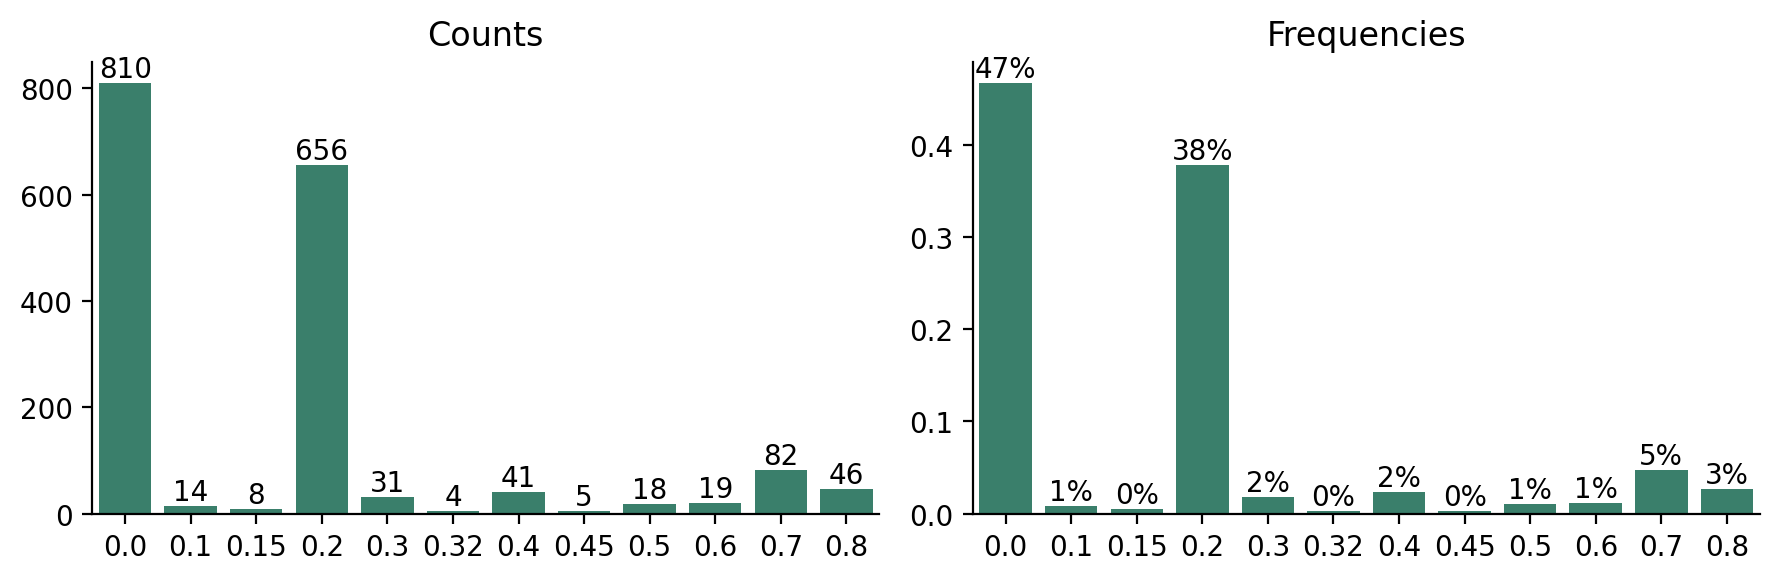

QUANTITY


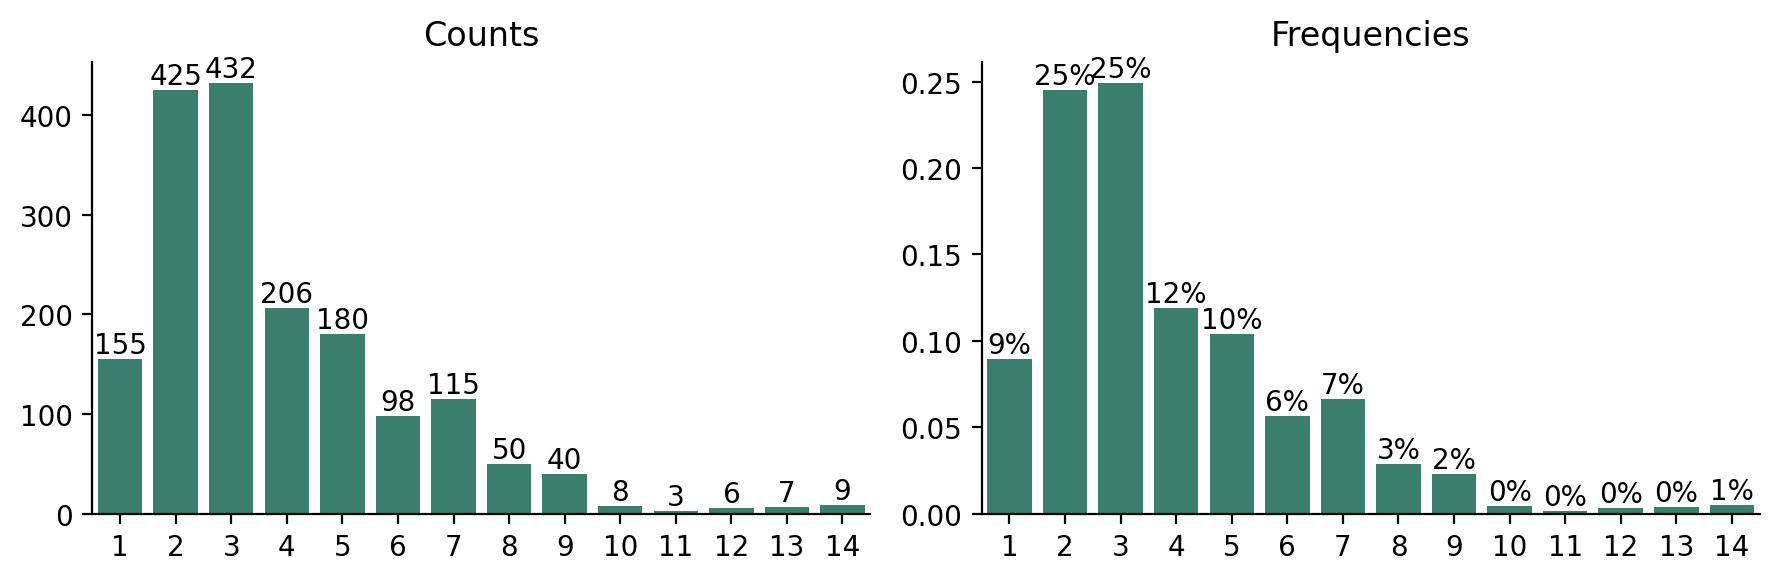

In [5]:
e.plot_counts(df, ['discount', 'quantity'])

Notes on data:
- 47% of items have no discount, 38% have a 20% discount, and the rest have discounts of other discount rates
- Half of sales are items bought in quantities of 2 or 3

---
## 2. Optimal Discount Rates

Determine the optimal discount rates for business metrics.

**Bivariate Analysis:** Discount vs. Profit/Sales/Margin

What are the counts and frequencies of our discount ranges?

In [6]:
pd.DataFrame([df.groupby('discount_bin').size(),
              round(df.groupby('discount_bin').size() / len(df), 2)
             ]).T.rename(columns={0: 'counts', 1: 'frequencies'})

,counts,frequencies
discount_bin,,
0,810.0,0.47
.1 - .2,678.0,0.39
>.2,246.0,0.14


How do discount rates affect business metrics?

In [7]:
aggregation_functions = {
    'sales': ['median', 'sum'], 'profit': ['median', 'sum'],
    'cost': ['median', 'sum'], 'margin': ['median'],
    'quantity': ['median', 'sum'], 'price': ['median'] }

df.groupby('discount_bin')[['sales', 'profit', 'cost',
                            'margin', 'quantity', 'price']]\
                          .agg(aggregation_functions).round(2)

sales            profit             cost            margin  \
             median        sum median       sum median        sum median   
discount_bin                                                               
0             47.04  168123.22  14.54  51268.77  29.89  116854.45   0.34   
.1 - .2       63.98  147013.91   6.70  16055.08  50.84  130958.82   0.16   
>.2           49.99   82306.70 -21.02 -29383.32  75.25  111690.02  -0.70   

             quantity         price  
               median   sum  median  
discount_bin                         
0                 3.0  3059   47.04  
.1 - .2           3.0  2542   79.97  
>.2               3.0   979  126.92

Insights:
- How do different discount rates impact sales?
    - **Sales seem to slightly increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**
- Other Insights:
    - High-cost and high-priced items are discounted more than low-priced items, as expected.
    - Discounted and non-discounted items should be analyzed separately based on their price range.

- Is there a specific discount percentage that leads to the highest profit margins?

What are the counts and frequencies of our specific discounts?

In [8]:
pd.DataFrame([df.groupby('discount').size(),
              round(df.groupby('discount').size() / len(df), 2)
             ]).T.rename(columns={0: 'counts', 1: 'frequencies'}).head()

,counts,frequencies
discount,,
0.00,810.0,0.47
0.10,14.0,0.01
0.15,8.0,0.00
0.20,656.0,0.38
0.30,31.0,0.02


In [9]:
df.groupby('discount')[['sales', 'profit', 'cost',
                            'margin', 'quantity', 'price']]\
                          .agg(aggregation_functions).round(2).head()

sales             profit              cost            margin  \
          median        sum  median       sum  median        sum median   
discount                                                                  
0.00       47.04  168123.22   14.54  51268.77   29.89  116854.45   0.34   
0.10      577.25   12254.17  104.92   2252.48  473.11   10001.69   0.18   
0.15      272.82    3250.78   11.24     40.68  253.14    3210.11   0.04   
0.20       56.78  131508.96    6.45  13761.93   47.09  117747.03   0.16   
0.30      388.43   18198.50  -29.25  -1840.44  430.87   20038.93  -0.09   

         quantity         price  
           median   sum  median  
discount                         
0.00          3.0  3059   47.04  
0.10          4.0    61  641.39  
0.15          2.0    30  320.97  
0.20          3.0  2451   70.98  
0.30          3.0   130  554.90

- **10% discount rates generate the most profit, but there are few items sold at this discount rate, and they are expensive items, so there's not enough evidence to conclude that this is the profit-maximizing discount rate.**
- There is only enough data at 20%, so we can't compare it to other discount rates to see which generates the most profit.

See correlations for metrics

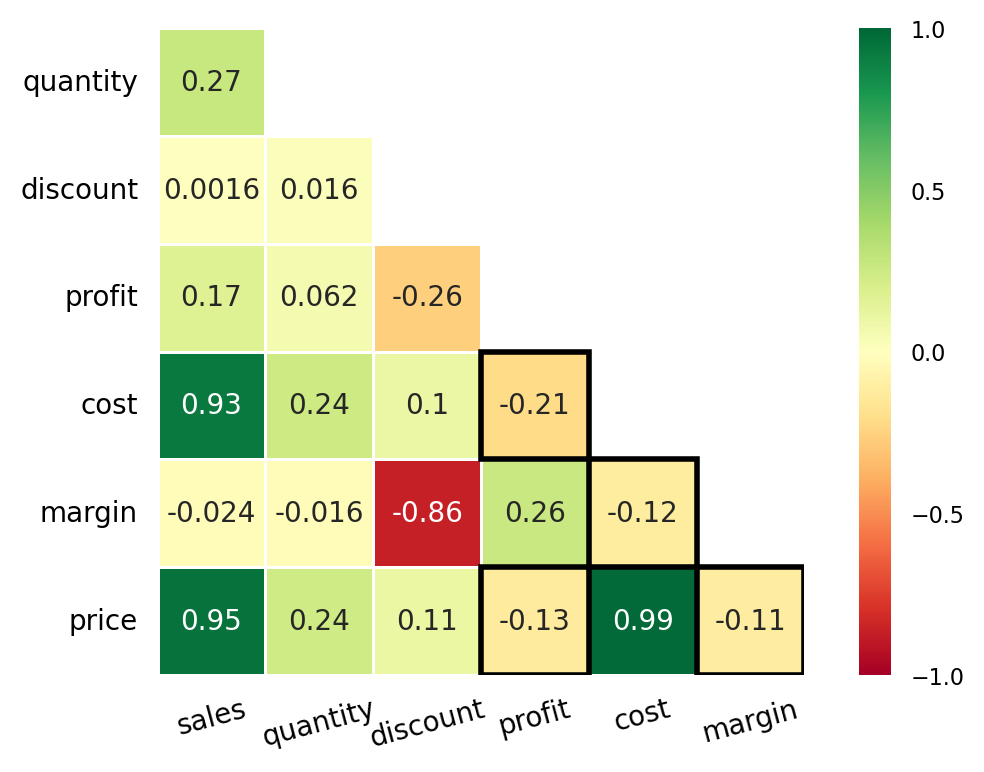

In [10]:
e.plot_correlations(df)

- **profit and profit margin have some negative correlation to cost and price, meaning expensive items are not generating as much profit as low-priced items.**

**Multivariate Analysis: Discount vs. Profit/Sales/Margin on low, medium, and high-priced items**

* Only low discounts, 10-20%, will be analyzed *

First, I want to analyze the sales data to get an idea of how many items are priced in certain price ranges.
- cheap items (under \\$20), 25% of sales
- medium-priced items (between \\$20 and \\$100), 33% of sales
- expensive items (between \\$100 and \\$300), 19% of sales
- very-expensive items (over \\$300), 22% of sales

Now to analyze discount rate effects on various priced items.

In [11]:
# group items by price
cheap_df = df[df['price_bin'] == 'cheap']
med_df = df[df['price_bin'] == 'medium']
exp_df = df[df['price_bin'] == 'expensive']
v_exp_df = df[df['price_bin'] == 'very-expensive']

***Cheap items:***

In [12]:
e.analyze_discount_rates(cheap_df)

Counts:


,counts,frequencies
discount_bin,,
0,221.0,0.52
.1 - .2,158.0,0.37
>.2,48.0,0.11


Metrics:


sales          profit         margin quantity     
             median      sum median     sum median   median  sum
discount_bin                                                    
0             10.56  2378.08   4.07  961.44   0.46      2.0  558
.1 - .2       10.25  1560.09   2.73  415.56   0.32      2.0  413
>.2            2.94   153.96  -2.94 -141.77  -0.77      2.5  131

Insights on cheap items:
- How do different discount rates impact sales?
    - **Sales don't increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

Plot distributions

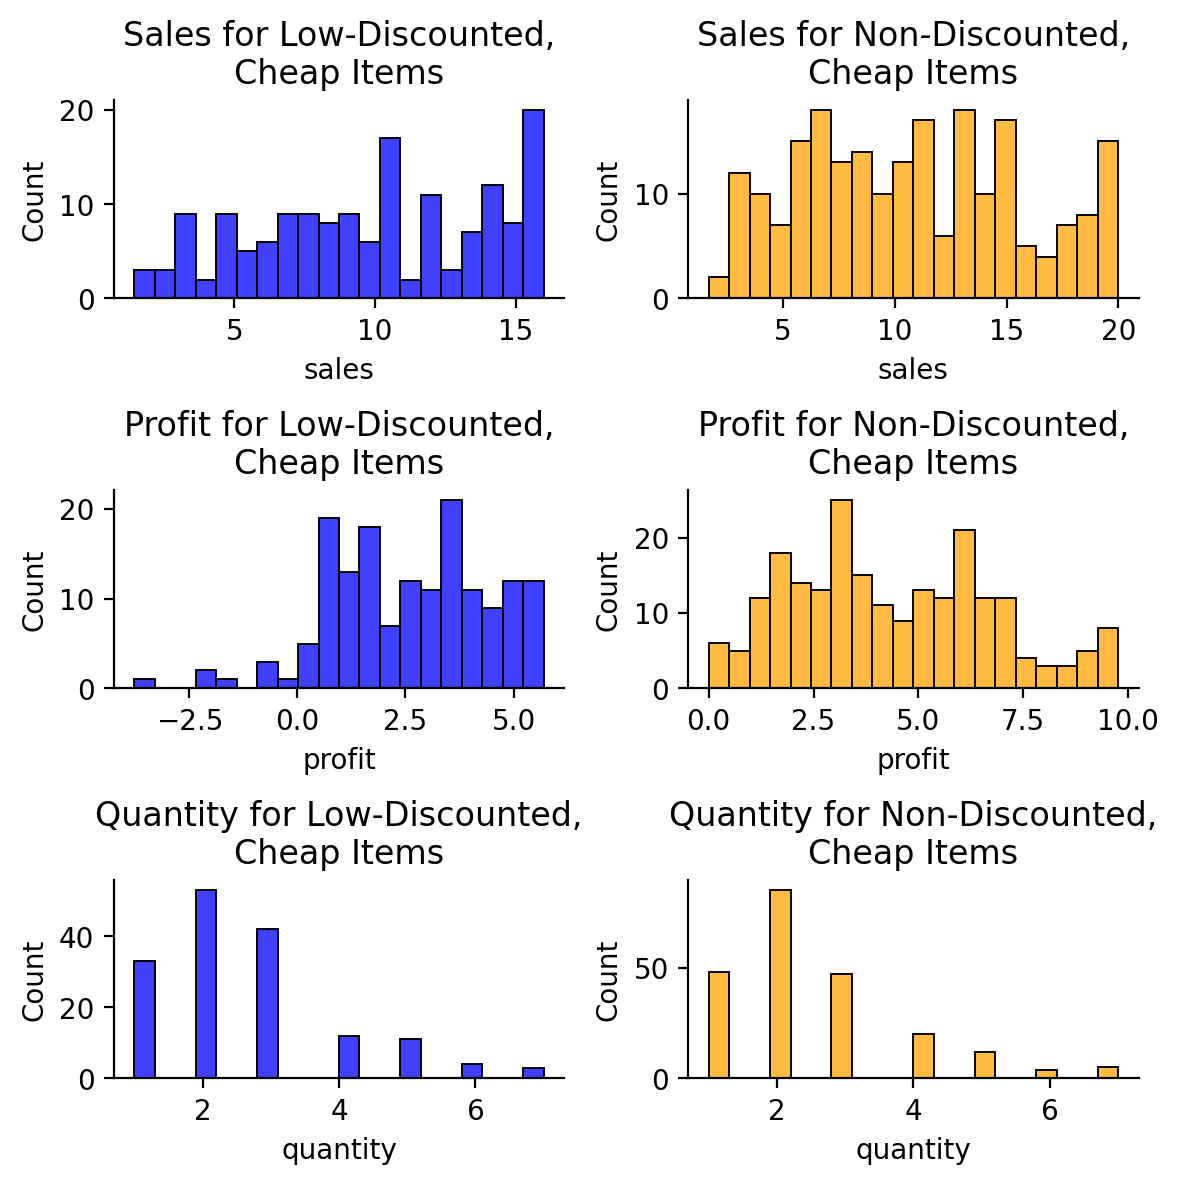

In [13]:
e.plot_metric_distributions(cheap_df, 'Cheap')

***Medium-priced items:***

In [14]:
e.analyze_discount_rates(med_df)

Counts:


,counts,frequencies
discount_bin,,
0,309.0,0.53
.1 - .2,206.0,0.36
>.2,63.0,0.11


Metrics:


sales           profit          margin quantity      
             median       sum median      sum median   median   sum
discount_bin                                                       
0             40.99  14861.35  14.35  5068.24   0.39      3.0  1194
.1 - .2       31.98   7783.01   6.63  1610.94   0.31      3.0   771
>.2           14.95   1158.97 -12.53  -792.55  -0.73      3.0   223

Insights on medium-priced items:
- How do different discount rates impact sales?
    - **Sales don't increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

Plot distributions

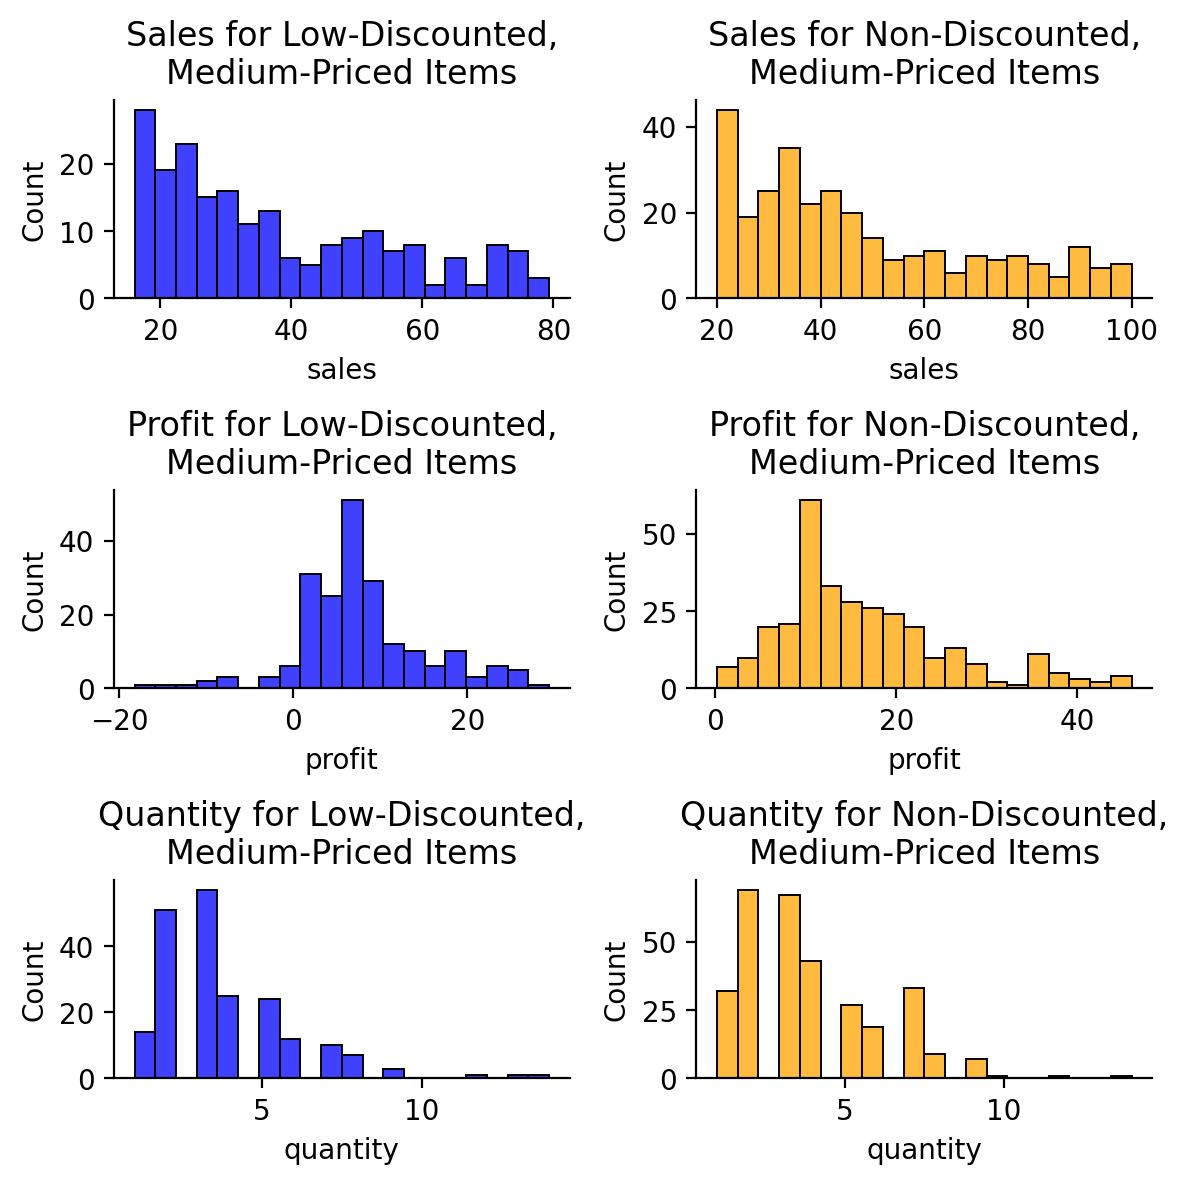

In [15]:
e.plot_metric_distributions(med_df, 'Medium-Priced')

***Expensive items:***

In [16]:
e.analyze_discount_rates(exp_df)

Counts:


,counts,frequencies
discount_bin,,
0,153.0,0.46
.1 - .2,139.0,0.41
>.2,44.0,0.13


Metrics:


sales           profit          margin quantity     
              median       sum median      sum median   median  sum
discount_bin                                                       
0             167.96  27277.68  51.76  7919.43   0.29      3.0  632
.1 - .2       130.46  19733.78  16.01  2230.82   0.10      3.0  527
>.2            69.01   3239.22 -32.41 -1861.23  -0.68      3.0  195

Insights on expensive items:
- How do different discount rates impact sales?
    - **Sales actually decrease on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

Plot distributions

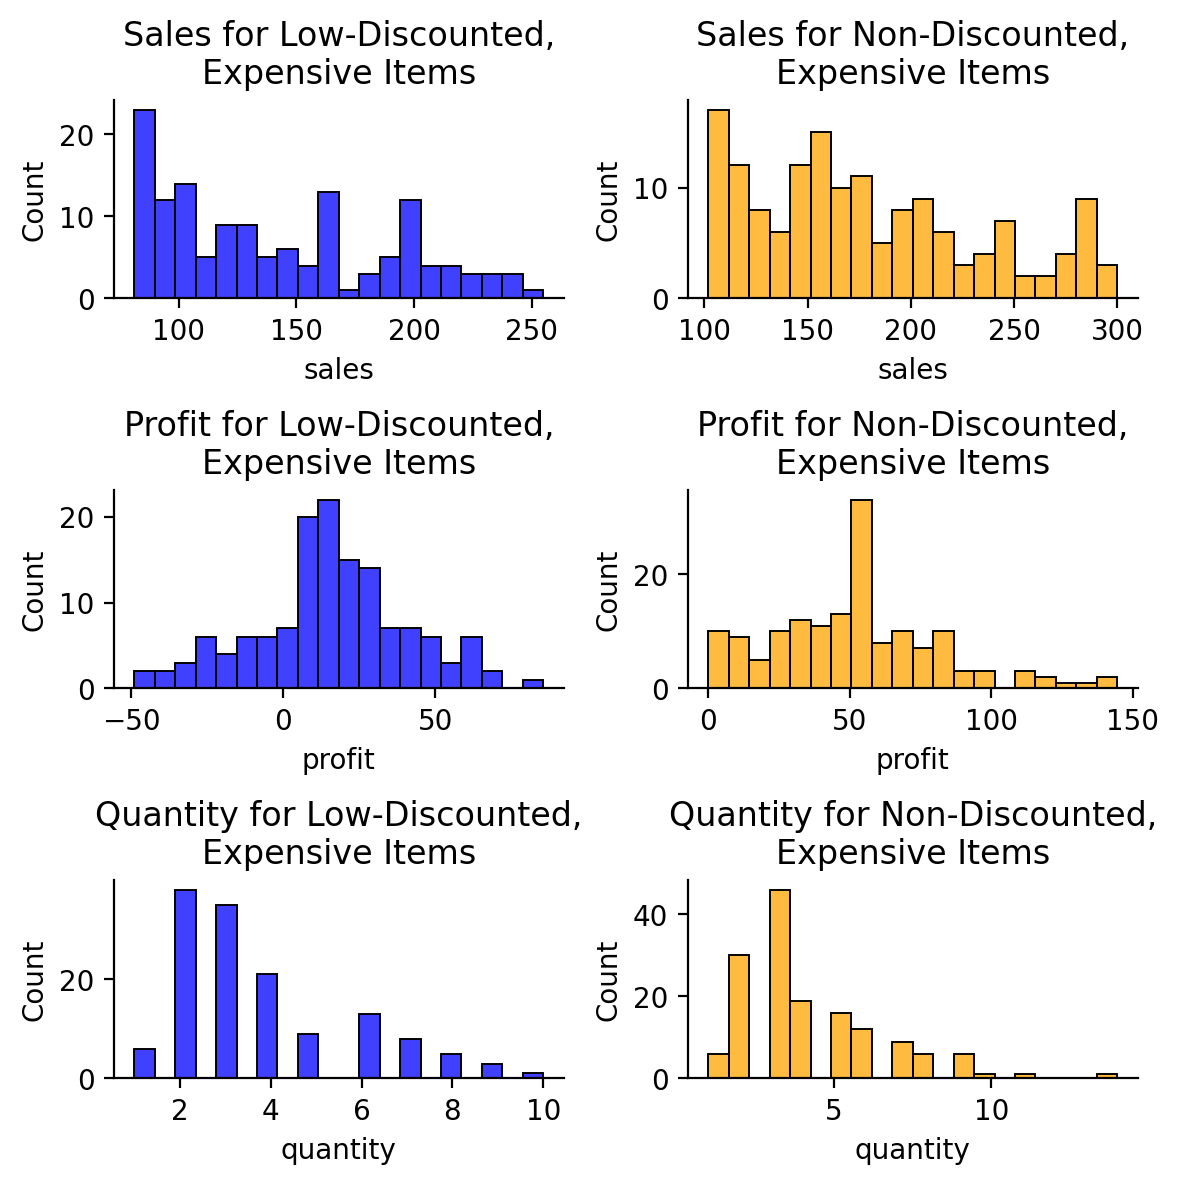

In [17]:
e.plot_metric_distributions(exp_df, 'Expensive')

***Very expensive items:***

In [18]:
e.analyze_discount_rates(v_exp_df)

Counts:


,counts,frequencies
discount_bin,,
0,127.0,0.32
.1 - .2,175.0,0.45
>.2,91.0,0.23


Metrics:


sales             profit           margin quantity     
              median        sum  median       sum median   median  sum
discount_bin                                                          
0             646.74  123606.11  166.10  37319.67   0.26      5.0  675
.1 - .2       466.77  117937.03   43.84  11797.78   0.09      4.0  831
>.2           479.99   77754.55 -153.35 -26587.77  -0.30      4.0  430

Insights on very expensive items:
- How do different discount rates impact sales?
    - **Sales actually decrease on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't increase with discounts.**
    

Plot distributions

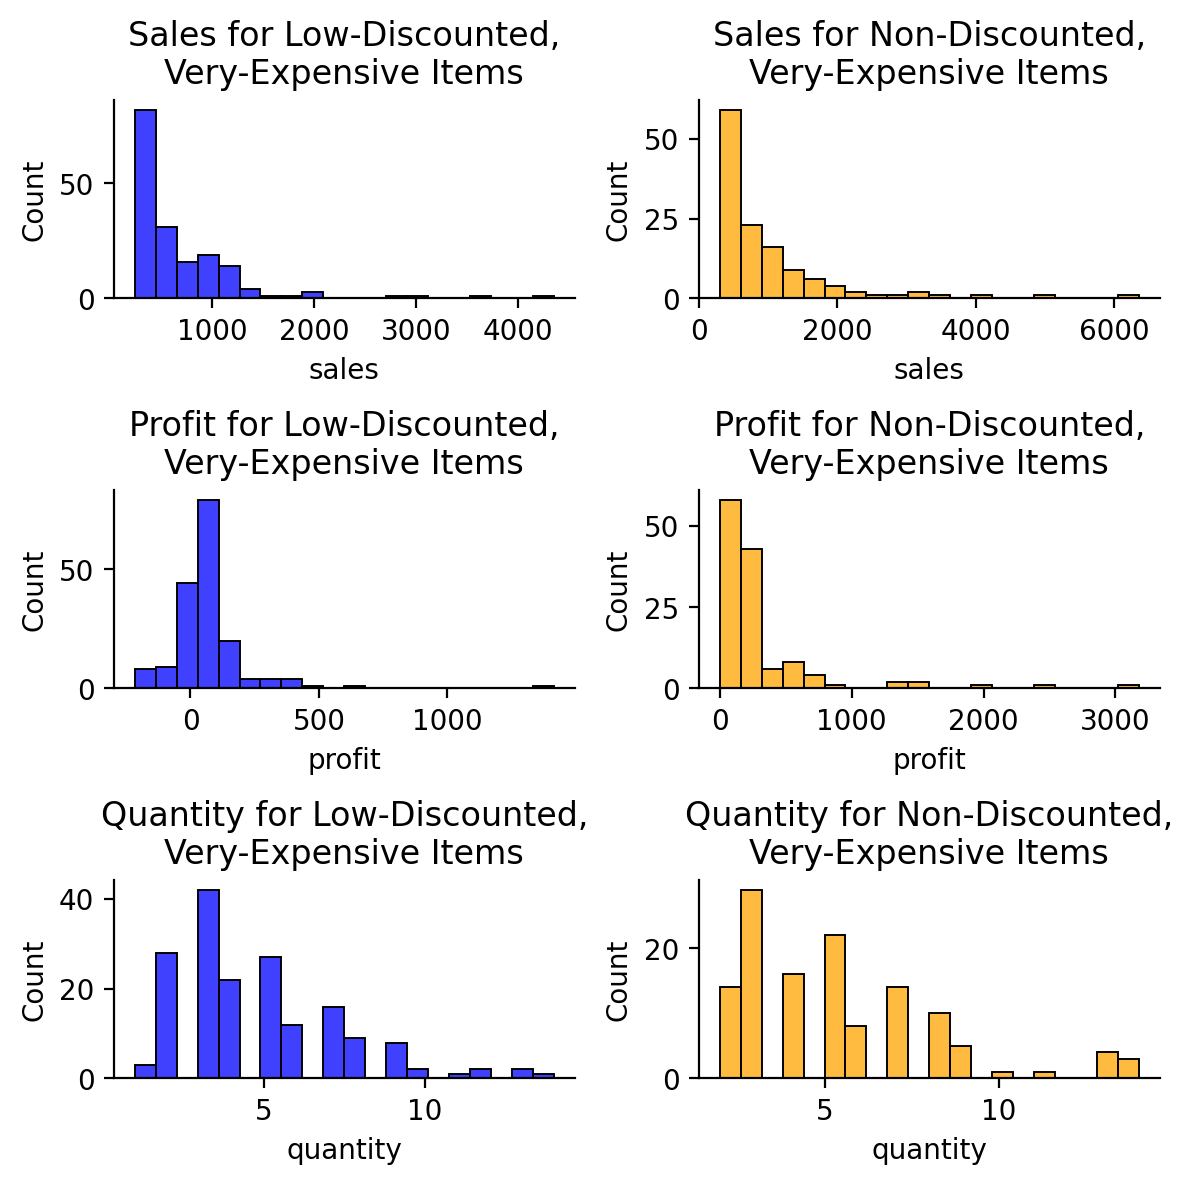

In [19]:
e.plot_metric_distributions(v_exp_df, 'Very-Expensive')

**Stats test**: Mann-Whitney's test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [20]:
e.run_mann_whitneys_tests(cheap_df, med_df, exp_df, v_exp_df)

,item_price,metric,H0,Ha,u_Statistic,p-value,significant_difference
1,\$0 - \$20,profit,Null Hypothesis: Average profit for low-discou...,Alternative Hypothesis: Average profit for low...,10594.5,0.000,yes
4,\$20 - \$100,profit,Null Hypothesis: Average profit for low-discou...,Alternative Hypothesis: Average profit for low...,13726.0,0.000,yes
7,\$100 - \$300,profit,Null Hypothesis: Average profit for low-discou...,Alternative Hypothesis: Average profit for low...,3905.5,0.000,yes
10,$300+,profit,Null Hypothesis: Average profit for low-discou...,Alternative Hypothesis: Average profit for low...,4454.0,0.000,yes
2,\$0 - \$20,quantity,Null Hypothesis: Average quantity for low-disc...,Alternative Hypothesis: Average quantity for l...,18219.0,0.453,no
5,\$20 - \$100,quantity,Null Hypothesis: Average quantity for low-disc...,Alternative Hypothesis: Average quantity for l...,31005.5,0.614,no
8,\$100 - \$300,quantity,Null Hypothesis: Average quantity for low-disc...,Alternative Hypothesis: Average quantity for l...,9747.0,0.210,no
11,$300+,quantity,Null Hypothesis: Average quantity for low-disc...,Alternative Hypothesis: Average quantity for l...,9823.0,0.082,no
0,\$0 - \$20,sales,Null Hypothesis: Average sales for low-discoun...,Alternative Hypothesis: Average sales for low-...,16086.0,0.192,no
3,\$20 - \$100,sales,Null Hypothesis: Average sales for low-discoun...,Alternative Hypothesis: Average sales for low-...,22951.0,0.000,yes


Test Conclusion and Results

- P-Value (`p_val`): A p value of .20, for example means there is a 20% chance we would observe the data if the null hypothesis (independence) is true. A p-value under .05 means we can conclude that there is statistical significance.


**Sales:** We can conclude that outside of cheap items, discounted items decrease sales. Discounted, cheap items show no significant difference in sales as non-discounted, cheap items.
<br>**Profit:** We can conclude that discounted items significantly decrease profits.
<br>**Quantity:** We can conclude that discounted items do not decrease or increase quantity of items sold.

---
## 4. Customer Impact

Analyze customer response to discounts.

Do returning customers see more discounted orders than non-returning customers?

Create DataFrame where one row represents a unique order

In [21]:
orders = e.items_to_orders(df)

What proportion of orders came from returning customers?

In [22]:
orders['returning_customer'].mean().round(2)

0.84

What proportion of orders from returning customers ever saw a discount?
<br>What proportion of orders from non-returning customers ever saw a discount?

In [23]:
print('Proportion of returning-customer orders that are discounted:')
print(orders[orders['returning_customer'] == 1]['has_discount'].mean().round(2))

print('Proportion of non-returning-customer orders that are discounted:')
print(orders[orders['returning_customer'] == 0]['has_discount'].mean().round(2))

Proportion of returning-customer orders that are discounted:
0.62
Proportion of non-returning-customer orders that are discounted:
0.53


We see a 9% difference in our sample data. With a small sample size, however, statistical testing should be done to see if we can conclude that having a discount leads to customers returning.

Are discounts and customer return dependent of each other?
- perform $\chi^2$ test to see if there is a dependent relationship between customer return and discounts.


**Stats test**: $\chi^2$ Test to compare proportions of discounted orders and orders from returning customers.

1. Hypotheses
- Null Hypothesis $H_o$: Customer retention is independent of having a discount
- Alternative Hypothesis $H_\alpha$: Customer retention is dependent of having a discount
- significance level ($\alpha = .05$)


2. Calculate test statistics and p-value. Perform test on contigency table.

In [24]:
observed = pd.crosstab(orders['returning_customer'], orders['has_discount'])
observed

has_discount,0,1
returning_customer,,
0,64,71
1,270,436


In [25]:
chi2, p_val, degf, expected = stats.chi2_contingency(observed)
chi2, p_val, expected

(3.6013962029775275,
 0.05773106644532114,
 array([[ 53.61474435,  81.38525565],
        [280.38525565, 425.61474435]]))

3. Test Conclusion and Results
- Test Statistic (`chi2`): A small chi2 value indicates a small difference between the observed and expected frequencies.
- P-Value (`p_val`): A p value of .058 means there is a 5.8% chance we would observe this data if discounts and customer return were independent (null hypothesis). This probability is not low enough to reject the null hypothesis.
- Expected Values (`expected`): <br>Below are the expected values it the null hypothesis were true: 

|has_discount     | 0 | 1 |
|-----------------|---|---|
|returning_customer|  |  |
|0| 54 | 81|
|1| 280| 425|

The expected values are similar to our observed values

**Test Conclusion** 
<br>Because our p-value is greater than our significance level, $\alpha$, we fail to reject the null hypothesis. **The evidence isn't significant enough to conclude that having a discount leads to customers returning.**

---

## Exploration Summary

During exploration of the sales data, several noteworthy insights were uncovered to shed light on the effectiveness of different discount rates and their impact on profits, sales, and quantity of items sold.

### Optimal Discount Rates and Profit Generation

- 10% discount rates generate the most profit. However, few items are sold at this discount rate and those that are are expensive items. Thus, there is not enough evidence to conclude that this is the optimal discount rate that would drive sales while maintaining profit.
- A sufficient amount of data is only available for the 20% discount rate, making it challenging to compare its performance against other discount rates. <u>**Further data collection would be required to draw meaningful conclusions**</u> in this regard.

### Mann-Whitney's Test Conclusions: Do Discounts Drive Business Metrics as Expected?

Short Answer: **No**

- **Sales:** With the exception of cheap items, discounted items lead to decreased sales. Discounted cheap items show no significant difference in sales compared to non-discounted cheap items.
- **Profit:** Discounted items significantly reduce profits.
- **Quantity:** Discounted items do not seem to have a significant impact on the quantity of items sold.

### Chi-Square Test Conclusion: Do Discounts Drive Customer Return?

Short Answer: **No**

- The chi-squared test results indicate that <u>**the data is not significant enough to conclude that offering a discount leads to an increase in customer retention**</u>. The observed proportions of discounted orders from returning and non-returning customers are similar to the expected proportions that would seen if discounts and customer return were independent.

### Correlations between Profit and Item Price

- Another interesting finding is that both profit and profit margin exhibit a negative correlation with cost and price. This indicates that <u>**higher-priced items are not yielding as much profit as lower-priced items**</u>.

In summary, our initial thoughts, which would be ideal for the business, did not turn out to be true. Discounts are not increasing sales or maintaining profits. Discounts are also not driving customer return or quantity of items sold. There was not enough data to find an optimal discount rate that would drive sales and maintain profit.

## Recommendations and Next Steps

Based on the insights gained from the exploration of the sales data, the following recommendations and next steps can be suggested to guide the company's approach towards discounts:

**Data Collection for Optimal Discount Rates:** Since the exploration did not yield sufficient data to conclusively identify the optimal discount rate that maximizes both sales and profits, more data should be gathered across a wider range of discount rates. This will allow for a more comprehensive analysis and evidence-based decision-making.

**Impact on Customer Loyalty:** Delve deeper into customer behavior after a discount. Implement post-purchase surveys or feedback mechanisms to understand whether discounts influence customer loyalty, repeat purchases, and overall satisfaction.

**Promotional Strategies:** On the same note, consider promoting or emphasizing discounts to attract customers and drive customer loyalty.

**Continuous Monitoring and Analysis:** Sales dynamics and customer preferences can evolve over time. Sales data should be analyzed regularly to identify emerging trends, revisit discount strategies, and adjust discounts as needed.

In conclusion, the exploration of the sales data has highlighted the relationships between discounts, profits, and customer behavior. Implementing the above recommendations and next steps will allow the company to make more informed decisions about discount strategies, better cater to customer needs, and optimize overall profitability.